# Univariate Time Series Model of Wind Generation

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from datetime import datetime, timedelta

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam


import warnings
warnings.simplefilter(action="ignore")

In [7]:
# Guidance from https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py

In [8]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/temperature/texas_temp.csv')

In [9]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [10]:
temp_df.head()

,Date,Temp
0,1/1/11,45.0
1,2/1/11,48.7
2,3/1/11,61.8
3,4/1/11,70.3
4,5/1/11,74.1


In [11]:
df = df[['date', 'NGas']]

df['date']=pd.to_datetime(df['date'])

df = df[df['date'].dt.day == 1]

df.reset_index(inplace=True)

df.drop(columns='index',inplace=True)

df_full = pd.concat([df, temp_df], axis =1)

In [12]:
df_full

,date,NGas,Date,Temp
0,2011-01-01,248086.363990,1/1/11,45.0
1,2011-02-01,218819.159530,2/1/11,48.7
2,2011-03-01,343441.973030,3/1/11,61.8
3,2011-04-01,202053.382820,4/1/11,70.3
4,2011-05-01,472446.061500,5/1/11,74.1
...,...,...,...,...
115,2020-08-01,721716.604984,8/1/20,84.3
116,2020-09-01,651271.628603,9/1/20,74.0
117,2020-10-01,445206.272739,10/1/20,65.9
118,2020-11-01,347772.901358,11/1/20,60.6


In [13]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
df_full.set_index('date', inplace=True)

In [14]:
df_full

,NGas,Temp
date,,
2011-01-01,248086.363990,45.0
2011-02-01,218819.159530,48.7
2011-03-01,343441.973030,61.8
2011-04-01,202053.382820,70.3
2011-05-01,472446.061500,74.1
...,...,...
2020-08-01,721716.604984,84.3
2020-09-01,651271.628603,74.0
2020-10-01,445206.272739,65.9


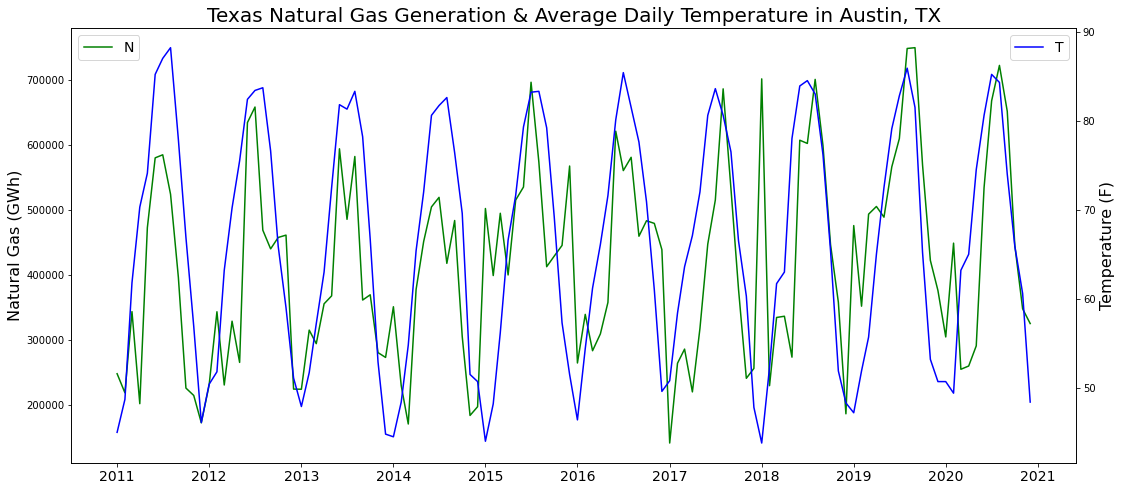

In [53]:
fig, ax = plt.subplots(figsize = (18,8))
plt.title('Texas Natural Gas Generation & Average Daily Temperature in Austin, TX', fontsize=20)

ax2 = ax.twinx()
ax.plot(df_full['NGas'], color = 'green')
ax2.plot(df_full['Temp'], color ='blue')
plt.rc('xtick', labelsize=14)
ax.legend('Natural Gas', loc='upper left', fontsize=14)
ax2.legend('Temperature', fontsize=14)
ax.set_ylabel('Natural Gas (GWh)', fontsize=16)
ax2.set_ylabel('Temperature (F)', fontsize=16)
plt.show()

### Because Natural Gas and Temperautre are on such different scales, let's apply a standard scaler

In [16]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
values = df_full.values

In [18]:
# Ensure all data is float
values = values.astype('float32')

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [20]:
reframed = series_to_supervised(scaled, 1, 1)

In [21]:
# split into train and test sets
values = reframed.values
n_train = 96
train = values[:n_train, :]
test = values[n_train:, :]

In [22]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(96, 1, 3) (96,) (23, 1, 3) (23,)


In [24]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, activation ='relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [25]:
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

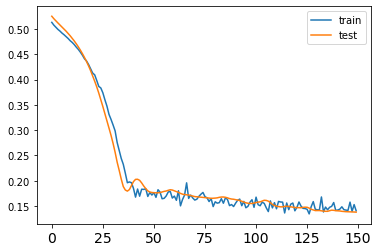

In [26]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [28]:
yhat_series = pd.Series(list(yhat))

In [29]:
yhat_series = pd.Series(yhat)

Exception: Data must be 1-dimensional

In [ ]:
new_test_X = pd.Series(list(test_X))
new_test_X

In [ ]:
# invert scaling for forecast
inv_yhat = pd.concat((yhat_series, new_test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


### Because Natural Gas and Temperautre are on such different scales, let's apply a standard scaler

In [ ]:
df_full

In [ ]:
X = df_full
y = df_full['NGas'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

In [ ]:
plt.figure(figsize =(11, 6))
plt.plot(X_train, c='blue')
plt.plot(X_test, c ='orange')

## Scaling

In [ ]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Preprocessing

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(X_train_sc, X_train_sc, length=n_input, batch_size=1)

### Reshape our data

In [ ]:
model = Sequential()
model.add(LSTM(200, activation = 'relu', input_shape=(n_input, n_features)))
model.add(Dense(1))

model.compile(optimizer= Adam(learning_rate=0.01), loss='mse')
model.summary()

In [ ]:
history= model.fit_generator(generator, epochs=150, verbose=0)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
trainPredict = model.predict_generator(train_sequences)
testPredict = model.predict_generator(test_sequences)

In [ ]:
n_forecast = 24  # period length of forecasts - in this case, months


In [ ]:
forecast = model.predict_generator(train_sequences[0][-n_forecast:])

In [ ]:
n_input = 12
n_features = 1

pred_list = []

batch = X_train_sc[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(m.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [ ]:
n_forecast = 24  # period length of forecasts - in this case, months

# create a list of dates based on training dates, start at first training date and create list of length n_forecast
forecast_period_dates = pd.date_range(start=list(df_full.index)[-1], periods=n_forecast, freq='MS').tolist()   

In [ ]:
forecast_period_dates

In [ ]:
# make predictions on our model based on the training data. Use  
forecast = model.predict(train_sequences[0:][-n_forecast:])

In [ ]:
np.reshape(np.array(train_sequences[0]), [1,2])

In [ ]:
np.reshape(train_sequences, [1,2])